# Siamese Facial Recognition Model 



 A Siamese Neural Network is a type of neural network architecture that involves two or more (in this case two) identical subnetworks that share the same weights and are used to compare or find the similarity between two inputs. It is commonly used in image recognition, signature verification, and natural language processing tasks.
 
 
 
 

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

#### Here are our steps:


##### 1. Designing the Siamese Model 

##### 2. Importing and Preprocessing Data

##### 3. Training


### 1. Designing the Model

Following picture summarizes our neural network architecture (Koch & et al, 2015):

#### 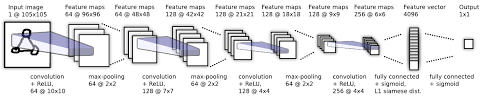

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten  #importing different level types
import tensorflow as tf

##### defining layers in the model

In [3]:
def make_embedding():
    
    inp = Input(shape = (105,105,3))   
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)
    
    c2= Conv2D(128,(7,7), activation='relu')(m1)
    m2=MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128,(4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
    
    c4 = Conv2D(256,(4,4),padding='same')(m3)
    f1 = Flatten()(c4)
    d1=Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs= [inp], outputs=[d1], name='make_embedding' )

In [4]:
make_embedding = make_embedding()
make_embedding.summary()

Model: "make_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)    

##### defining the distance custom layer 

In [5]:
class L1Distance(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

##### now that all layers are created, we can man our Siamese Model

In [6]:
def make_siamese_model():
    
    input_image = Input(name='input_img', shape=(105,105,3))
    
    validation_image = Input(name = 'validation_image', shape = (105,105,3))
    
    siamese = L1Distance()
    
    distance = siamese(make_embedding(input_image), make_embedding(validation_image))
    
    #creating the last layer, 1*1 inary classifier
    
    classifier = Dense(1, activation='sigmoid')(distance)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'siamese_model' )

In [7]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 make_embedding (Functional)    (None, 4096)         86146368    ['input_img[0][0]',              
                                                                  'validation_image[0]

##### here is a summary of what we did so far

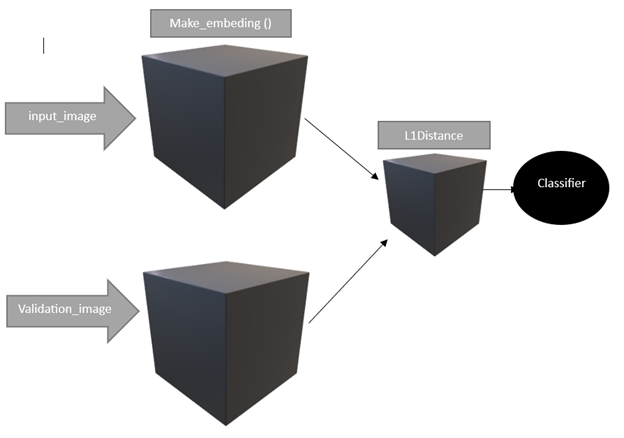

# 2. Importing and Preprocessing Data


##### for this project I have used Kaggle LFW Face Recognition data. You may download it using following link: https://www.kaggle.com/datasets/atulanandjha/lfwpeople

In [ ]:
!tar -xf lfw-funneled.tgz

##### We should move all images in the data set into one folder, Negative folder.

In [8]:
Positive = os.path.join('data', 'positive')
Negative = os.path.join ('data', 'Negative')
Anchor = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(Positive)
os.makedirs(Negative)
os.makedirs(Anchor)

##### Note: in the data set there are some files called Pair. remove them from the data set and then run following codes. 

In [9]:
for folder in os.listdir('lfw_funneled/'):
    for file in os.listdir(os.path.join('lfw_funneled/', folder)):
        expired_path = os.path.join('lfw_funneled/', folder, file)
        new_path = os.path.join(Negative, file)
        os.replace(expired_path, new_path)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



##### now that we collect our negative example, it is time to collect positive and anchor data. 

In [ ]:
import uuid

In [ ]:
cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    if ret:
        frame = frame[120:120+250,200:200+250,:] 
    
    if cv2.waitKey(120) & 0xff== ord('a'):
        image = os.path.join(Anchor, '{}.jpg'.format(uuid.uuid4()))
        
        cv2.imwrite(image, frame)
        
    if cv2.waitKey(1) & 0xff ==ord('p'):
        image2 = os.path.join(Positive, '{}.jpg'.format(uuid.uuid4()))
        
        cv2.imwrite(image2, frame)
        
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) & 0xff == ord('q'):
        break

        
cap.release()
cv2.destroyAllWindows()
    
    
    

##### Creating our data sets

using 'tf.data.Dataset.list_files' we create a dataset y loading data from files

In [9]:
anchor = tf.data.Dataset.list_files(Anchor+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(Positive+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(Negative+'/*.jpg').take(300)



In [10]:
anchor.as_numpy_iterator().next()

b'data\\anchor\\05dad971-f0e3-42c7-a912-4ac61cf1aad1.jpg'

##### Preprocessing data
as the input of the system is 105*105 px images, we should change all images' size

In [11]:
def processing(path):
    
    img = tf.io.read_file(path)
    
    decoded_img = tf.image.decode_jpeg(img)
    
    resized_img = tf.image.resize(decoded_img, [105,105])
    
    normalized_img = resized_img/255
    
    return normalized_img

In [12]:
img = processing('data\\anchor\\fbb08473-6e7c-49e3-b9a6-c2b0035e3918.jpg')

In [13]:
img.numpy().max()

1.0

##### adding lable to positive and negative examples

In [14]:
positive_lable = tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))
negative_lable = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

## combining anchor, positive/ negative , and lable data set using Zip

labled_positive = tf.data.Dataset.zip((anchor, positive, positive_lable))

labled_negative = tf.data.Dataset.zip((anchor, positive, negative_lable))

data = labled_positive.concatenate(labled_negative)

In [15]:
example = data.as_numpy_iterator()

example= example.next()

example


(b'data\\anchor\\ba969232-967b-4ecd-b68c-db00f82affe6.jpg',
 b'data\\positive\\c91025e1-da08-4f89-81f3-cd58130691e5.jpg',
 1.0)

In [16]:
def processing_twin(input_img, validation_img, lable):
    return (processing(input_img), processing(validation_img), lable)
    

In [17]:
data = data.map(processing_twin)

#Caching can help to speed up the training process, 
#especially if you have a large dataset that takes a long time to load. 
#By default, the cache() method caches the dataset in memory, but you can also pass a filename to cache the dataset on disk instead.
data = data.cache() 

data = data.shuffle(buffer_size = 1024)

In [18]:
sam = data.as_numpy_iterator()
len(sam.next())

3

# 3. Training

##### Deviding data into training set and test set

In [19]:
train_data = data.take(round(len(data)*0.70))

train_data = train_data.batch(16)  #deviding mini-batches with 16 examples in each

train_data = train_data.prefetch(8) #starts processing in advance

# train = train_data.as_numpy_iterator()
# train = train.next()
# np.array(train).shape

In [20]:
test_data = data.skip(round(len(data)*0.70))

test_data = data.take(round(len(data)*0.3))

test_data = test_data.batch(16)

test_data = test_data.prefetch(8)

# test = test_data.as_numpy_iterator()
# test = test.next()
# np.array(test).shape

##### importing Loss function and Optimizer


In [21]:
loss_function = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)   #0.0001

In [22]:
@tf.function 

def training_step(batch):
    
    with tf.GradientTape() as tape:
        x = batch[:2]    #features of the model
        
        y = batch[2]     #taret of the model
        
        y_pred = siamese_model(x, training= True)
        
        loss = loss_function(y, y_pred)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    optimizer.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    return loss        
        

In [23]:
def training(data, EPOCHS):
    #loop trhough epochs
    
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
    
        #Loop through each batch
        for idx, batch in enumerate(data):
            #Run train step here
            x = training_step(batch)
            
#             print(x)
            progbar.update(idx+1)      
    print(x)

##### Train the model 

In [24]:
EPOCHS = 50

training(train_data, EPOCHS)


 Epoch 1/1
27/27 [==============================] - 589s 22s/step
tf.Tensor(0.69612443, shape=(), dtype=float32)


# 4. Model Evaluation


In [25]:
from tensorflow.keras.metrics import Precision, Recall

test_input, test_validation, y_true = test_data.as_numpy_iterator().next()
y_true

array([1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

In [26]:
y_pred = siamese_model.predict([test_input, test_validation])
y_pred

1/1 [==============================] - 2s 2s/step


array([[0.5084913 ],
       [0.50157595],
       [0.509749  ],
       [0.5009221 ],
       [0.49781522],
       [0.49943027],
       [0.5221687 ],
       [0.5298926 ],
       [0.5191158 ],
       [0.55764365],
       [0.5579327 ],
       [0.5140635 ],
       [0.51055753],
       [0.49956867],
       [0.53418696],
       [0.5449007 ]], dtype=float32)

In [28]:
[1 if prediction >0.5 else 0 for prediction in yhat]

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

In [29]:
m = Recall()

#calculating recall value
m.update_state(y_true, yhat)

#accessing the result 
m.result().numpy()


0.6666667

In [30]:
m = Precision()

#calculating recall value
m.update_state(y_true, yhat)

#accessing the result 
m.result().numpy()

0.46153846

# 5. Visualizing Results

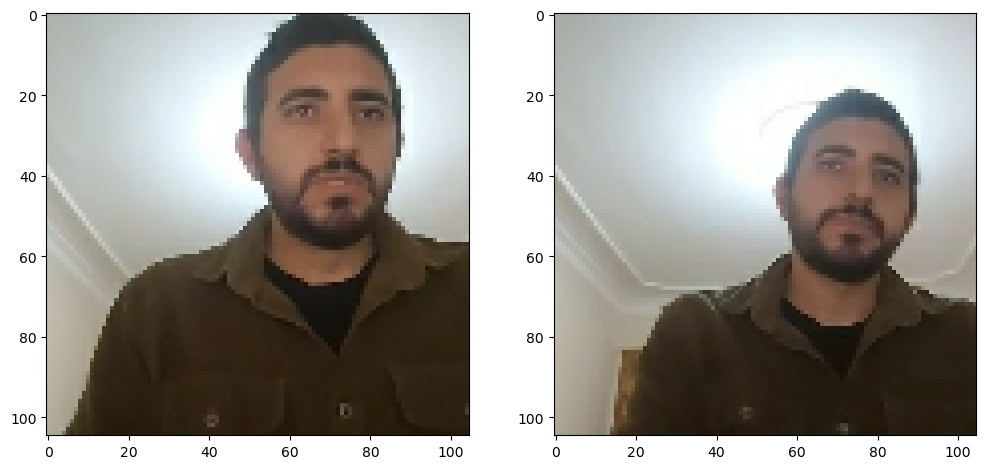

In [31]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)

plt.imshow(test_input[1])

plt.subplot(1,2,2)

plt.imshow(test_validation[1])

plt.show()

# 6. Saving the Model


In [32]:
siamese_model.save('Siamese_Model_Face_Recognition')


INFO:tensorflow:Assets written to: Siamese_Model_Face_Recognition\assets


INFO:tensorflow:Assets written to: Siamese_Model_Face_Recognition\assets


# 7. Loading the Model

In [33]:
model = tf.keras.models.load_model('Siamese_Model_Face_Recognition', custom_objects={'L1Distance':L1Distance, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

# 8. Real Time Test and Evaluation

##### First we want to copy 50 image from ou positive directory to a new directory called 'verification_image' .

In [34]:
import shutil
 

In [36]:
verification=  os.path.join('application_data', 'verification_image')
os.makedirs(os.path.join('application_data', 'input_img'))
os.makedirs(verification)


In [39]:
def number_of_verification_images(number):
    
    verification=  os.path.join('application_data', 'verification_image')
    for file in os.listdir(verification):
        file_path = os.path.join('application_data', 'verification_image', file)
        if os.path.isfile(file_path):
            os.unlink(file_path)


    if not os.path.exists(verification):
        verification = os.path.join('application_data', 'verification_image')
        os.makedirs(verification)

    image_files = os.listdir(Positive)
    for i, image_file in enumerate(image_files):
        if i >= number:
            break           
        source_path = os.path.join(Positive, image_file)
        destination_path = os.path.join(verification, image_file)
        shutil.copyfile(source_path, destination_path)
        
        
    

In [45]:
def verify(model, detection_treshhold, vertification_treshhold, number_of_verification_image):
#detection treshhold is the possibility of True outcome, meaning that the similarity between 
#input_img and validation_img should be more than detection_treshhold in order to consider as True outcome 
    
    number_of_verification_images(number_of_verification_image)
    
    results= []
    
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = processing((os.path.join('application_data','input_img','input_image.jpg')))
        validation_img = processing(os.path.join('application_data','verification_image', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))        
        results.append(result)
    
    detection = np.sum(np.array(results)>detection_treshhold)    #it returns True or False and counts the number of Trues.
    
    verificationrate = detection/number_of_verification_image
    verified = verificationrate>vertification_treshhold
        
    return results, verified

# OpenCV Real Time Test

In [46]:
import cv2
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame = frame[120:120+250,200:200+250,:]  #we deine which part of the picture to put on the frame

    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF ==ord('c'):
        imgname = os.path.join('application_data', 'input_img','input_image.jpg')

        #save input image into input image folder
        cv2.imwrite(imgname, frame)
        
        results, verified = verify(model, 0.5,0.5, 50)
        print(verified)
  
    
    if cv2.waitKey(10) & 0xFF ==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 272ms/step
True
1/1 [==============================] - 0s 356ms/step
True
1/1 [==============================] - 0s 298ms/step
True
